In [1]:
import numpy as np
import sys; sys.path.append('../rrr')
from multilayer_perceptron import *
from figure_grid import *
from local_linear_explanation import *

# 2D Intuition for Input Gradients

The goal of this notebook is to show how input gradients relate to a model's decision boundary. In particular, we'll create two simple 2D datasets with different numbers of classes (and pretty arbitrary actual boundaries), then compute and plot input gradients as vector fields.

## 2-class dataset

Let's do the simple, binary classification case:

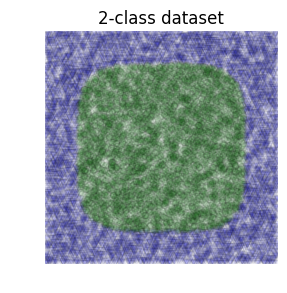

In [23]:
true_fn = lambda x,y: x**4 + y**4

X = np.random.random((20000,2))*100-50
mean = np.mean([true_fn(x,y) for x,y in X])*0.66
y = np.array([true_fn(x,y) > mean for x,y in X]).astype(int)
pos = X[np.argwhere(y==1).T[0]]
neg = X[np.argwhere(y==0).T[0]]

plt.figure(figsize=(3,3))
plt.title("2-class dataset")
plt.xlim(-50,50)
plt.ylim(-50,50)
plt.scatter(pos[:,0], pos[:,1], c='blue', marker='v', alpha=0.05)
plt.scatter(neg[:,0], neg[:,1], c='green', alpha=0.05)
plt.axis('off')
plt.show()

In [32]:
mlp = MultilayerPerceptron()
mlp.fit(X,y)
mlp.score(X,y)

0.99465000000000003

Because we're using a powerful model like an MLP, we can classify this dataset very well despite the nonlinear decision boundary.

We can take gradients with respect to the log probability of predicting 0, the log probability of predicting 1, or of the maximum log probability (e.g. the predicted class).

In [35]:
grads0 = mlp.input_gradients(X, y=0)
grads1 = mlp.input_gradients(X, y=1)
gradsp = mlp.input_gradients(X)

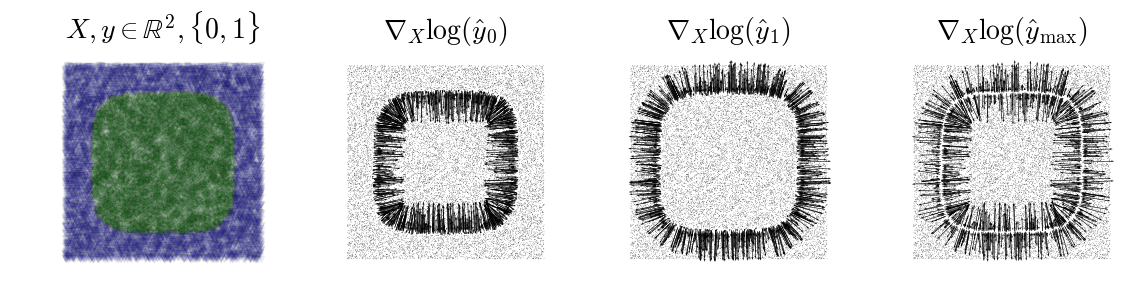

In [36]:
plt.figure(figsize=(14,3))
fs = 20

def plot_grads(X, grads):
  plt.axis('off')
  plt.quiver(X[:,0], X[:,1], grads[:,0], grads[:,1])
  
plt.subplot(141)
plt.axis('off')
plt.title(r'$X,y\in\mathbb{R}^2,\{0,1\}$', fontsize=fs)
plt.scatter(pos[:,0], pos[:,1], c='blue', marker='v', alpha=0.05)
plt.scatter(neg[:,0], neg[:,1], c='green', alpha=0.05)

plt.subplot(142)
plt.title(r'$\nabla_X \log(\hat{y}_0)$', fontsize=fs)
plot_grads(X, grads0)

plt.subplot(143)
plt.title(r'$\nabla_X \log(\hat{y}_1)$', fontsize=fs)
plot_grads(X, grads1)

plt.subplot(144)
plt.title(r'$\nabla_X \log(\hat{y}_{\max})$', fontsize=fs)
plot_grads(X, gradsp)

plt.show()

This hopefully provides some intuition about what input gradients are / mean; they help define the decision boundary and lie normal to it. Zooming in a little closer:

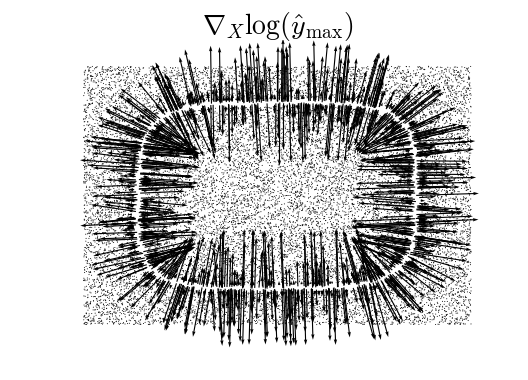

In [39]:
plt.title(r'$\nabla_X \log(\hat{y}_{\max})$', fontsize=fs)
plot_grads(X, gradsp)
plt.show()

We see that near the boundary, we can maximize the probability of the predicted class by moving _away_ from the boundary, which makes sense.

Let's look at an example with more classes:

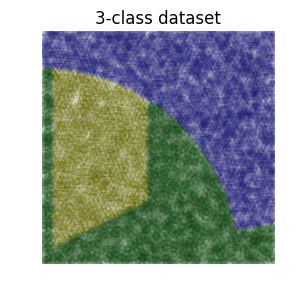

In [21]:
X2 = np.random.random((30000,2))*100

def y_fn(x,y):
  if x**2 + y**2 > 7000 and 3*x - 17*y < 14:
    return 0
  elif x**2.5 + 12*np.sin(y) < 50 or x > 45 or y < 5 + 0.5*x:
    return 1
  else:
    return 2

y2 = np.array([y_fn(x,y) for x,y in X2])
kls1 = X2[np.argwhere(y2==0).T[0]]
kls2 = X2[np.argwhere(y2==1).T[0]]
kls3 = X2[np.argwhere(y2==2).T[0]]

plt.figure(figsize=(3,3))
plt.title("3-class dataset")
plt.xlim(0,100)
plt.ylim(0,100)
plt.scatter(kls1[:,0], kls1[:,1], c='blue', marker='v', alpha=0.05)
plt.scatter(kls2[:,0], kls2[:,1], c='green', alpha=0.05)
plt.scatter(kls3[:,0], kls3[:,1], c='yellow', marker='^', alpha=0.05)
plt.axis('off')
plt.show()

In [22]:
mlp2 = MultilayerPerceptron()
mlp2.fit(X2,y2)
mlp2.score(X2,y2)

0.97213333333333329

In [24]:
grads2_1 = mlp2.input_gradients(X2, y=0)
grads2_2 = mlp2.input_gradients(X2, y=1)
grads2_3 = mlp2.input_gradients(X2, y=2)
grads2_p = mlp2.input_gradients(X2)

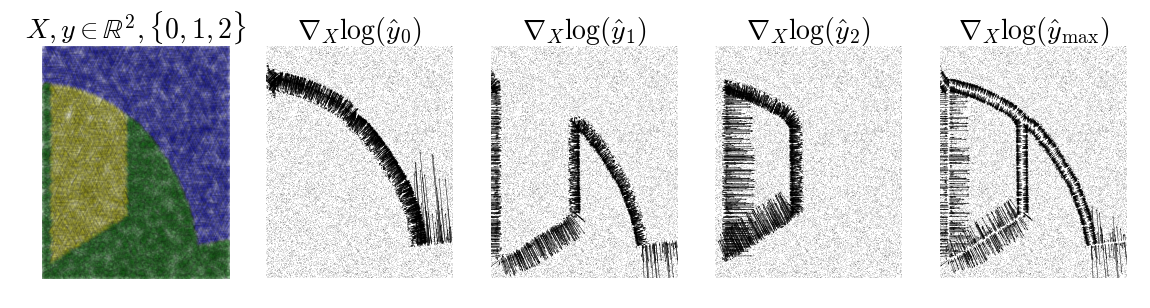

In [25]:
plt.figure(figsize=(14,3))
fs = 20

plt.subplot(151)
plt.title(r'$X,y \in \mathbb{R}^2,\{0,1,2\}$', fontsize=fs)
plt.xlim(0,100)
plt.ylim(0,100)
plt.scatter(kls1[:,0], kls1[:,1], c='blue', marker='v', alpha=0.05)
plt.scatter(kls2[:,0], kls2[:,1], c='green', alpha=0.05)
plt.scatter(kls3[:,0], kls3[:,1], c='yellow', marker='^', alpha=0.05)
plt.axis('off')

plt.subplot(152)
plt.title(r'$\nabla_X \log(\hat{y}_0)$', fontsize=fs)
plot_grads(X2, grads2_1)

plt.subplot(153)
plt.title(r'$\nabla_X \log(\hat{y}_1)$', fontsize=fs)
plot_grads(X2, grads2_2)

plt.subplot(154)
plt.title(r'$\nabla_X \log(\hat{y}_2)$', fontsize=fs)
plot_grads(X2, grads2_3)

plt.subplot(155)
plt.title(r'$\nabla_X \log(\hat{y}_{\max})$', fontsize=fs)
plot_grads(X2, grads2_p)

plt.show()

Even with multiple classes, input gradients still define the decision boundary between all of them pretty well. Clearly, the fact that they are small deep within regions makes sense, because moving around within the interior of a region shouldn't change the model's prediction. We'll enforce this later to improve accuracy.

It's also interesting to consider the different magnitudes:

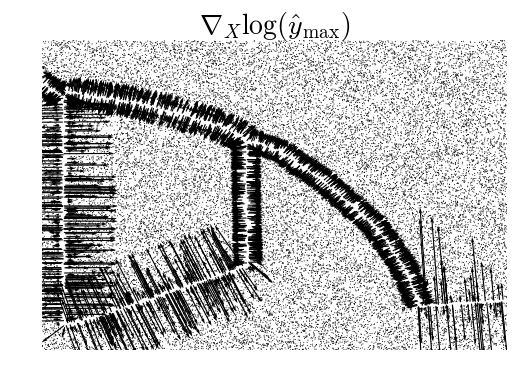

In [40]:
plt.title(r'$\nabla_X \log(\hat{y}_{\max})$', fontsize=fs)
plot_grads(X2, grads2_p)
plt.show()

The relative magnitudes are larger in some of the bottom boundaries than the top ones. Does this mean the model performs "better" or "worse" in different areas?